# Ridge regression with polynomial features of degree 2

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os

In [3]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- use grid search to find optimal values for the alpha parameter.

In [ ]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_grid = {'alpha': [ 1e-4, 1e-3, 1e-2, 0.1, 1.0]}
regr_cv = GridSearchCV(estimator=regr,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.9s finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', GridSearchCV(cv=None, error_score='raise',
   ...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2))])

Save model to AML shared directory

In [7]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,8.071834,0.075002,-1254.909901,-1026.437903,1,{'alpha': 1.0},1,-1331.436417,-999.838557,-1203.328295,-1039.932388,-1229.964990,-1039.542765,0.804378,0.014166,55.194258,18.809251
3,10.161840,0.093162,-1262.637908,-1019.471796,0.1,{'alpha': 0.1},2,-1347.240096,-993.642476,-1206.815383,-1032.219289,-1233.858244,-1032.553624,0.773314,0.012683,60.832977,18.264597
2,9.931501,0.089002,-1265.507298,-1017.347906,0.01,{'alpha': 0.01},3,-1350.927179,-992.095951,-1208.501572,-1029.980763,-1237.093142,-1029.967004,1.547650,0.014237,61.518488,17.855830
1,9.704336,0.088166,-1266.403337,-1017.034483,0.001,{'alpha': 0.001},4,-1349.382950,-991.856112,-1209.105907,-1029.707908,-1240.721153,-1029.539428,1.501017,0.005720,60.078244,17.803930
0,10.961910,0.097670,-1266.606758,-1017.027997,0.0001,{'alpha': 0.0001},5,-1349.163871,-991.850778,-1209.236706,-1029.702828,-1241.419698,-1029.530384,1.215020,0.014436,59.836966,17.803121


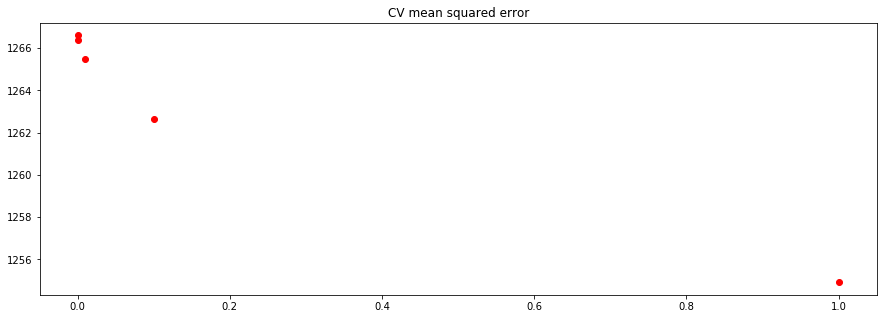

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(cv_results['param_alpha'], -cv_results['mean_test_score'], 'ro')
plt.title('CV mean squared error')
plt.show()